In [1]:
import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import time
import os   
import pickle
import pprint
import lit 


L = 1.0
T = 20.0
num_intervals = 10
total_time = num_intervals*T

num_switch_intervals = round(total_time/T)
#Pe = 'inf'
#kappa = 0.0
Pe = 2**11
kappa = 1./Pe
gamma = 1.0
f = 1./T
St = f/gamma

print('Pe = ', Pe)
print('St = ', St)

lb = (kappa / gamma)**0.5
l_smallest = 0.25 * lb  # a quarter of batchelor scale
print('lb = ', lb)
num_wavelengths = L / l_smallest
N_boyd = tools.N_boyd(num_wavelengths)
print('N_boyd = ',N_boyd)

N = min(N_boyd, 256)
#N = N_boyd
dt_cfl = 0.25 * min((L / N)**2. / kappa, (L / N) / (gamma * L))


# N=256
# dt_cfl = (L / N) / (gamma * L)

print('N = ', N)
print('dt_cfl = ', dt_cfl)
M_cfl = round(T / dt_cfl)
print('M_cfl = ', M_cfl)
#M = 8000
M = M_cfl
print('M = ', M)
dt = T/M
print('dt = ', dt)

Pe =  2048
St =  0.05
lb =  0.02209708691207961
N_boyd =  1024
N =  256
dt_cfl =  0.0009765625
M_cfl =  20480
M =  20480
dt =  0.0009765625


In [2]:
A = 2.**0.5/(2.*np.pi/L)
ftype = np.float64
ctype = np.complex128

st = tools.ScalarTool(N,L)
vt = tools.VectorTool(N,L)
print(L/A )
print(A)

4.442882938158366
0.22507907903927654


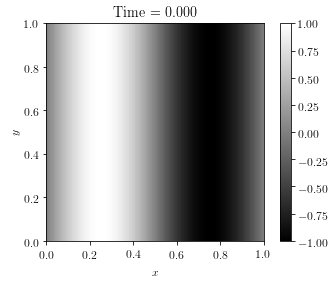

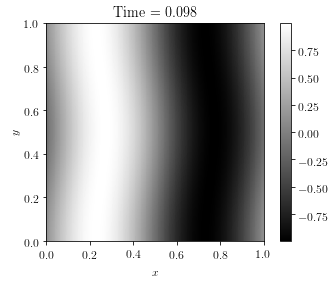

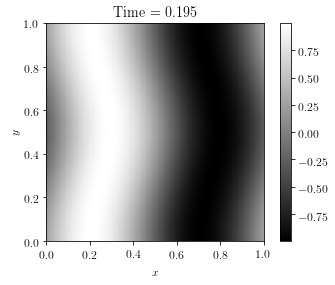

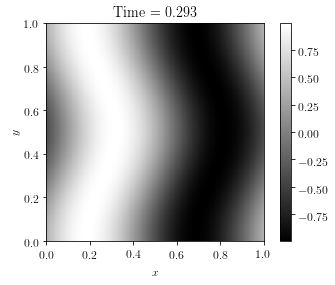

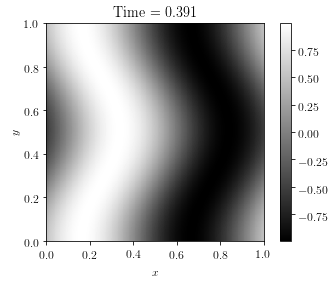

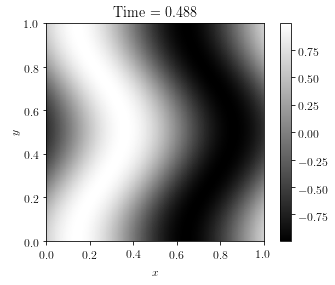

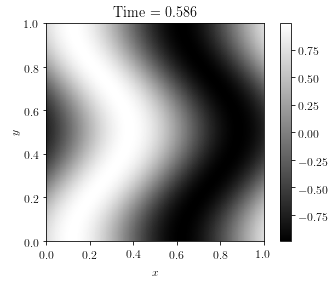

In [ ]:
output_path = 'output-sinflow-Pe='+str(Pe)+'-St='+str(St)+'/'

os.system('rm ' + output_path + 'images/*')
os.system('rm ' + output_path + '/*')

os.system('mkdir ' + output_path)
os.system('mkdir ' + output_path + 'images/')

def f(th,u):
    th_d = st.dealias(th)
    return st.dealias(-1.0 * np.sum(vt.dealias(u) * st.grad(th_d), 0) 
                      + kappa * st.lap(th_d))

th0 = np.sin(2.*np.pi/L*st.X[0])
th = copy.copy(th0)
steps = 0
time = 0
frame_num = 0

hist_l2norm = [st.l2norm(th)]
hist_hm1norm = [st.hm1norm(th)]
hist_mean = [np.mean(th)]
hist_time = [time]
hist_th = [th]

for i in range(num_switch_intervals):
    if i % 2 == 0:
        u = np.zeros((2,N,N))
        phi = np.random.uniform(0, 2*np.pi)
        u[0] = A*np.sin(2.*np.pi/L*st.X[1] + phi)
    else:
        u = np.zeros((2,N,N))
        phi = np.random.uniform(0, 2*np.pi)
        u[1] = A*np.sin(2.*np.pi/L*st.X[0] + phi)
        
    for j in range(M):
        if steps % 100 == 0:

            fig = plt.figure()

            st.plot(th,high_quality = True)
            plt.title('Time = %.3f' % time)
            plt.savefig(output_path + 'images/' + "image%.4d.png" % 
                        frame_num, format='png',dpi = 300)
            plt.show()
            plt.close(fig)
            
            hist_l2norm.append(st.l2norm(th))
            hist_hm1norm.append(st.hm1norm(th))
            hist_mean.append(np.mean(th))
            hist_time.append(time)
            hist_th.append(th)
            
            frame_num += 1
        
        
        k1 = f(th, u)
        k2 = f(th + 0.5 * dt * k1, u)
        k3 = f(th + 0.5 * dt * k2, u)
        k4 = f(th + dt * k3, u)
        th = th + dt * (1.0 / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

        time = time + dt
        
        steps += 1

# Save movie

In [ ]:
os.system("ffmpeg -y -framerate 80 -i " + output_path + 'images/'
      "image%04d.png -c:v libx264 -pix_fmt yuv420p " + output_path + "movie.mp4")


# Plotting

In [ ]:
plt.semilogy(hist_time,hist_l2norm)
plt.xlabel('Time t')
plt.ylabel('$L^{2}$ norm')
plt.savefig(output_path+'l2_norm.eps',format = 'eps',dpi = 300)
plt.show()


In [ ]:
plt.semilogy(hist_time,hist_hm1norm)
plt.xlabel('Time t')
plt.ylabel('$H^{-1}$ norm')
plt.savefig(output_path+'hm1_norm.eps',format = 'eps',dpi = 300)
plt.show()

In [ ]:
plt.plot(hist_time,np.array(hist_hm1norm)/np.array(hist_l2norm))
plt.savefig(output_path+'hm1-l2-ratio.eps',format = 'eps',dpi = 300)
plt.xlabel('Time t')
plt.ylabel('$H^{-1}-L^2$ ratio')
plt.show()

# Saving model

In [ ]:
model = {}
model['Pe'] = Pe
model['St'] = St
model['L'] = L
model['T'] = T
model['kappa'] = kappa
model['U'] = vt.l2norm(u)/L
model['gamma'] = vt.h1norm(u)/L
model['dt'] = dt
model['hist_l2norm'] = hist_l2norm
model['hist_hm1norm'] = hist_hm1norm
model['hist_mean'] = hist_mean
model['hist_time'] = hist_time 
model['hist_th'] = hist_th


In [ ]:
with open(output_path +'data.p', 'wb') as f:
    pickle.dump(model, f)

# Load model

In [ ]:
output_path =  'output-sinflow-Pe='+str(128)+'-St='+str(0.25)+'/'

with open(output_path + 'data.p', 'rb') as handle:
    model_load = pickle.load(handle)
    
hist_l2norm = model_load['hist_l2norm']
hist_hm1norm = model_load['hist_hm1norm']
hist_mean = model_load['hist_mean']
hist_time = model_load['hist_time']
# hist_th = model_load['hist_th']


